# Predicting Sale Prices Using Advanced Regression and Feature Engineering

In this notebook I have explored the House Prices dataset from Kaggle using several regression algorithms.
We’ll go through the complete machine learning workflow step by step:
- 🧹 Data exploration & cleaning

- ⚙️ Feature engineering

- 🧠 Model building & tuning

- 🤝 Model blending (XGBoost, LightGBM, Ridge, Lasso)

- 📊 Generating final predictions

### The end goal is to achieve a competitive relative error in  prediction of the Saleprice of Houses with maximum accuracy.

We begin by importing essential libraries for data handling, visualization, and modeling.
This includes `Pandas, NumPy, Seaborn, Matplotlib`, and multiple machine learning libraries like `Scikit-learn`, `XGBoost`, `LightGBM`, and `CatBoost`.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Display settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Key **observations** after loading the datasets:

- Train set has 1460 rows and 81 columns

- Test set has 1459 rows and 80 columns

- SalePrice is our target variable, available only in the training set.

# Initial Data Exploration

We examine the dataset to understand its structure and identify missing values.

- Many categorical columns like `PoolQC`, `Fence`, `Alley`, `MiscFeature` have large sections of missing data.

- Numeric features like `LotFrontage`, `GarageYrBlt`, and `MasVnrArea` have moderate missing values.

In [2]:
# Overview of training data
print("----- TRAIN DATA INFO -----")
train.info()

print("\n----- TEST DATA INFO -----")
test.info()



----- TRAIN DATA INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-

In [3]:
# Count missing values per column
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print(f"Total columns with missing values: {len(missing)}")
missing.head(20)


Total columns with missing values: 19


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

#### We will summarize numerical statistics using `.describe()` to check data spread, means, and possible outliers.

In [4]:
train.describe().T.head(15)

,count,mean,std,min,25%,50%,75%,max
Id,1460.000,730.500,421.610,1.000,365.750,730.500,1095.250,1460.000
MSSubClass,1460.000,56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,1201.000,70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,1460.000,10516.828,9981.265,1300.000,7553.500,9478.500,11601.500,215245.000
OverallQual,1460.000,6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,1460.000,5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,1460.000,1971.268,30.203,1872.000,1954.000,1973.000,2000.000,2010.000
YearRemodAdd,1460.000,1984.866,20.645,1950.000,1967.000,1994.000,2004.000,2010.000
MasVnrArea,1452.000,103.685,181.066,0.000,0.000,0.000,166.000,1600.000
BsmtFinSF1,1460.000,443.640,456.098,0.000,0.000,383.500,712.250,5644.000


## Understanding the Target Variable `(Saleprice)`:
**Insights:**
- The price distribution is right-skewed — most houses are moderately priced with a few expensive outliers.

- 75% of all houses cost below ~214,000 USD.

- Mean > Median confirms a right-skewed distribution.

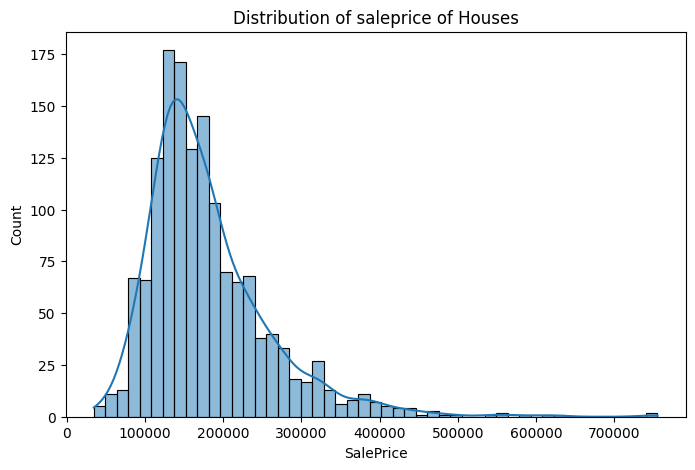

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


In [5]:
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'],kde=True)
plt.title('Distribution of saleprice of Houses')
plt.show()
print(train['SalePrice'].describe())


In [6]:
corr = train.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False)
corr.head(15)

SalePrice      1.000
OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
GarageYrBlt    0.486
MasVnrArea     0.477
Fireplaces     0.467
BsmtFinSF1     0.386
Name: SalePrice, dtype: float64

The above step also helps us realize why a **log transformation** will later improve model stability and reduce skewness.

# Visual Exploratory Data Analysis (EDA) for (Numeric features)
We compute correlations between numeric features and SalePrice.
Top correlated features:

- `OverallQual`

- `GrLivArea`

- `GarageCars`

- `TotalBsmtSF`

- `1stFlrSF`

  
Let's visualize how the top correlated numeric features relate to **SalePrice**.


In [ ]:
top_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea','TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(top_features[:6]):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(data=train, x=feature, y='SalePrice', alpha=0.7)
    plt.title(f'{feature} vs SalePrice')
plt.tight_layout()
plt.show()


Above, we can already see that:
- Higher **OverallQual** and **GrLivArea** strongly increase SalePrice.
- There are potential **outliers** — very large houses sold at lower prices.


# Outlier Handling & Categorical EDA

## Removing outliers:

In [8]:
# Identify potential outliers
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
display(outliers[['Id', 'GrLivArea', 'SalePrice']])

# Remove them from the training set
train = train.drop(outliers.index)

print(f"New train shape after removing outliers: {train.shape}")

,Id,GrLivArea,SalePrice
523,524,4676,184750
1298,1299,5642,160000


New train shape after removing outliers: (1458, 81)


We detected **extreme outliers**: houses with GrLivArea > 4000 but low SalePrice < 300000.

These can harm the model and introduce bias, so we remove them to improve model generalization.

## Exploring categorical data:

We will visualize relationships between categorical variables and SalePrice using **Boxplots**:

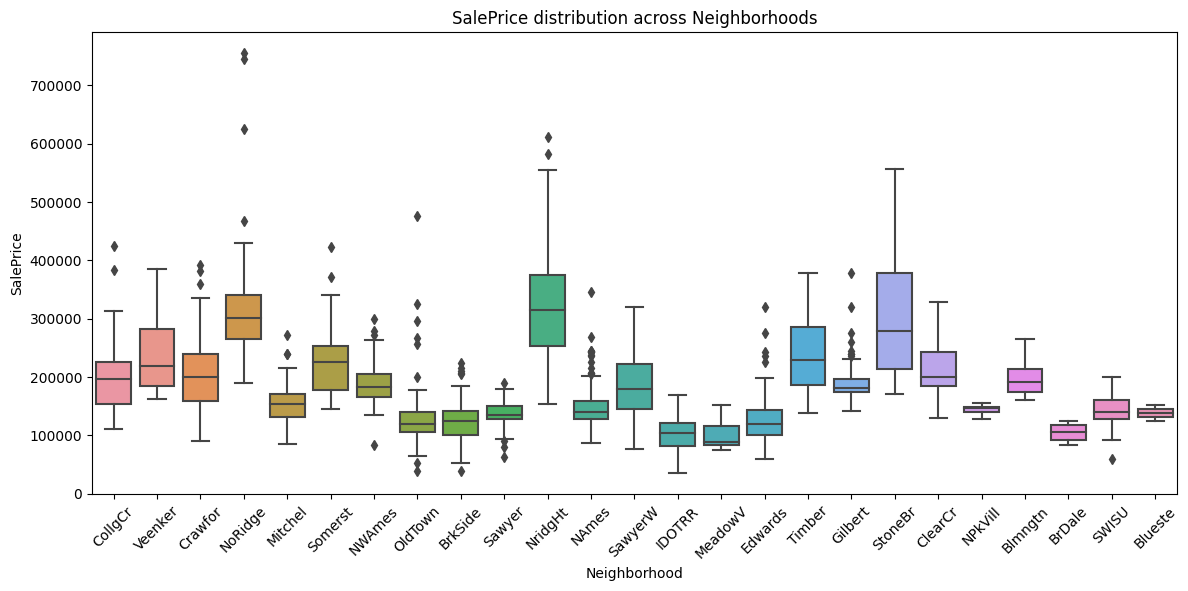

In [9]:
# Plot settings for exploring Categorical features
plt.figure(figsize=(14,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
plt.xticks(rotation=45)
plt.title('SalePrice distribution across Neighborhoods')
plt.show()


**Insights:**

After reviewing the above boxplot it can be seen that:

- `Neighborhood`: Some neighborhoods consistently have higher prices.


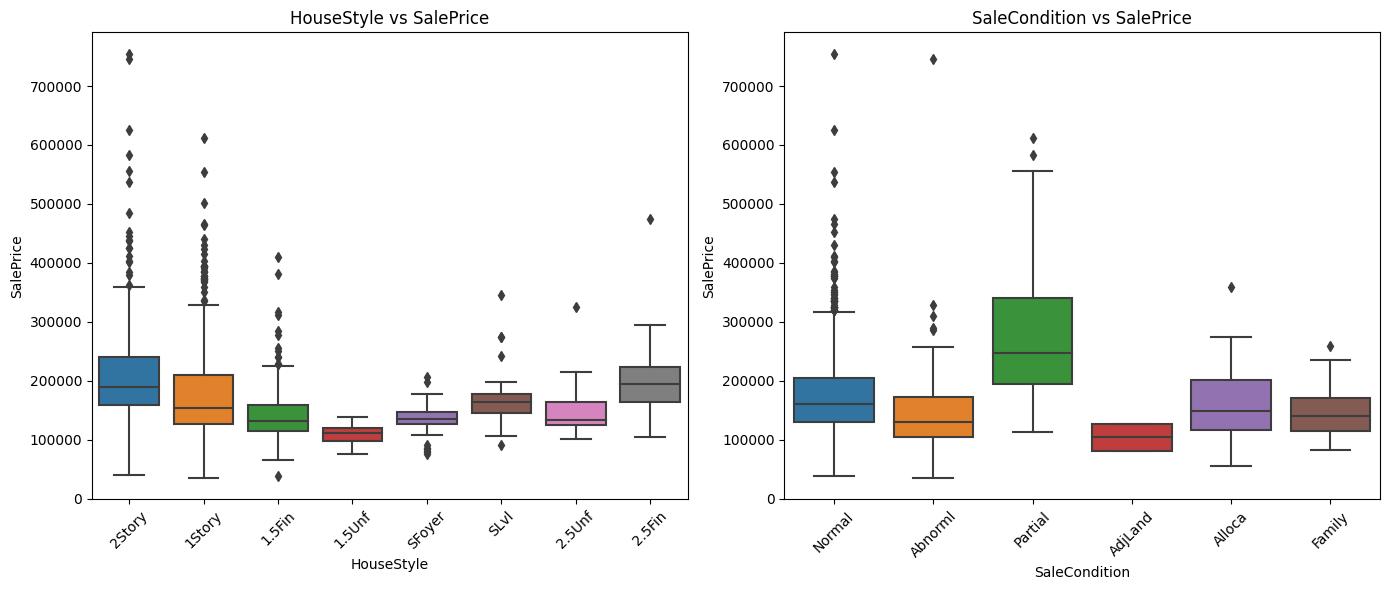

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.boxplot(x='HouseStyle', y='SalePrice', data=train, ax=axes[0])
axes[0].set_title('HouseStyle vs SalePrice')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='SaleCondition', y='SalePrice', data=train, ax=axes[1])
axes[1].set_title('SaleCondition vs SalePrice')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Insights 🧠**  
- `HouseStyle`: 2Story and 1Story homes tend to have higher prices, while 1.5Fin and 1.5Unf styles are cheaper.  
- `SaleCondition`: 'Partial' (new construction) sales are the most expensive.

  
These patterns confirm **categorical features are strong predictors**.


# Feaure Engineering and Data Prep

### Handling Missing Values and Imputation:

- Columns where NaN means “None” (e.g., `Alley`, `Fence`, `PoolQC`) are filled with "`None`".

- Numeric basement/garage values are replaced with `0`.

- LotFrontage is filled using the **median** per Neighborhood.

- GarageYrBlt missing → `0`.

- Electrical missing → value from **mode**.

In [11]:
import numpy as np
import pandas as pd

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


# Workin on a copy
df_train = train.copy()

# 1) Columns where NaN means "None"
none_cols = [
    'Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
    'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
    'PoolQC','Fence','MiscFeature','MasVnrType'
]
for c in none_cols:
    if c in df_train.columns:
        df_train[c] = df_train[c].fillna('None')

# Basement/garage 
zero_cols = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
             'BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','MasVnrArea']
for c in zero_cols:
    if c in df_train.columns:
        df_train[c] = df_train[c].fillna(0)

# LotFrontage: impute by Neighborhood median
if 'LotFrontage' in df_train.columns and 'Neighborhood' in df_train.columns:
    df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(
        lambda s: s.fillna(s.median())
    )

# GarageYrBlt: missing means no garage
if 'GarageYrBlt' in df_train.columns:
    df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(0)

# Electrical: single missing
if 'Electrical' in df_train.columns:
    df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

# sanity check of remaining NA
na_left = df_train.isna().sum()
na_left = na_left[na_left>0].sort_values(ascending=False)
print("Still missing after rules:")
print(na_left)


Still missing after rules:
Series([], dtype: int64)


Above output shows that there are **no missing values** anymore.

## Log-Transforming the target variable `SalePrice`:

We apply log transformation to SalePrice using np.log1p() bcause,

- it reduces the influence of extremely high-priced houses.
- Makes data more normally distributed.
- Helps linear models handle target variability better.

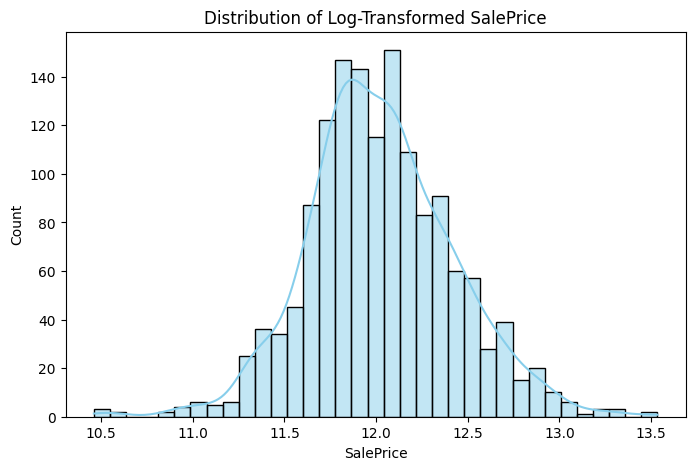

y mean: 12.024057394918406 y std: 0.3994492733225068


In [12]:
# Create a new target variable (log-transformed SalePrice)
y = np.log1p(train['SalePrice'])   # log(1 + SalePrice)

# Drop SalePrice and Id to get features
X = train.drop(columns=['SalePrice', 'Id'])

# Check transformation visually
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(y, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed SalePrice')
plt.show()

print("y mean:", y.mean(), "y std:", y.std())


Now the distribution of the target `SalePrice` above is not right-skewed anymore when it is log-tansformed.

## Encoding the categorical values:

We will separate numeric and categorical columns:

- Apply ordinal mappings to quality-related features (e.g., ExterQual, KitchenQual, BsmtQual, etc.).

- Remaining categorical features are one-hot encoded.

This encoding allows both linear and non linear models to process mixed data types correctly.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create a copy for safety
X = train.drop(columns=['SalePrice', 'Id']).copy()

# Ordinal mappings (keep meaningful order)
qual_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
bsmt_exp_map = {'None':0,'No':0,'Mn':1,'Av':2,'Gd':3}
bsmt_fin_map = {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
paved_map = {'N':0,'P':1,'Y':2}
bin_map = {'N':0,'Y':1}
functional_map = {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}

ordinal_maps = {
    'ExterQual': qual_map, 'ExterCond': qual_map,
    'BsmtQual': qual_map, 'BsmtCond': qual_map, 'BsmtExposure': bsmt_exp_map,
    'BsmtFinType1': bsmt_fin_map, 'BsmtFinType2': bsmt_fin_map,
    'HeatingQC': qual_map, 'KitchenQual': qual_map,
    'FireplaceQu': qual_map, 'GarageQual': qual_map, 'GarageCond': qual_map,
    'PoolQC': qual_map, 'PavedDrive': paved_map, 'CentralAir': bin_map,
    'Functional': functional_map
}

for col, mapping in ordinal_maps.items():
    if col in X.columns:
        X[col] = X[col].map(mapping).astype('float64')

# Split remaining columns by dtype
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {len(num_cols)} | Categorical columns: {len(cat_cols)}")

# Preprocess: imputers + one-hot encoder
numeric_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_proc, num_cols),
        ('cat', categorical_proc, cat_cols)
    ]
)

print("Encoding setup complete — ready for model training.")

Numeric columns: 52 | Categorical columns: 27
Encoding setup complete — ready for model training.


# Linear Model Training
## Baseline model training using Ridge Regression:

In [14]:
# Baseline Ridge Regression with 10-Fold Cross-Validation

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

# Create a Ridge regression model inside a pipeline
ridge = Pipeline(steps=[
    ('preprocessor', preprocess),
    ('model', Ridge(alpha=10.0, random_state=42))
])

# Define 10-fold cross-validation setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate using Root Mean Squared Log Error
scores = cross_val_score(
    ridge, X, y,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

print(f"Ridge 10-Fold CV log-RMSE: {-scores.mean():.4f} ± {scores.std():.4f}")


Ridge 10-Fold CV log-RMSE: 0.1374 ± 0.0379


**Insights:**

- CV log-RMSE: 0.1374 ± 0.0379

- This means we have now achieved a **`13.7%` relative prediction error**

## Hyperparameter tuning
Now that we have the baseline model ready, we can test multiple alpha (regularization) values using `RidgeCV` and `LassoCV`

In [15]:
from sklearn.linear_model import RidgeCV, LassoCV

# Define range of alpha values to test
alphas = np.logspace(-3, 3, 50)  # from 0.001 to 1000

# RidgeCV
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_root_mean_squared_error', cv=10)
ridge_cv.fit(preprocess.fit_transform(X), y)
print(f"Best Ridge alpha: {ridge_cv.alpha_:.4f}")

#LassoCV for comparison
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(preprocess.fit_transform(X), y)
print(f"Best Lasso alpha: {lasso_cv.alpha_:.4f}")


Best Ridge alpha: 10.9854
Best Lasso alpha: 0.0010


**Insights:**
- Ridge α ≈ `10.9854`
- Lasso α ≈ `0.0010`

Also note that the std deviation is still `0.0379`, we will also try to improve this.

## Rechecking Cross-Validation:

In [16]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
import numpy as np

best_alpha_ridge = 10.9854
best_alpha_lasso = 0.0010

ridge_best = Pipeline([
    ('preprocessor', preprocess),
    ('model', Ridge(alpha=best_alpha_ridge, random_state=42))
])

lasso_best = Pipeline([
    ('preprocessor', preprocess),
    ('model', Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=20000))
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)

ridge_scores = cross_val_score(ridge_best, X, y,
                               scoring='neg_root_mean_squared_error',
                               cv=cv, n_jobs=-1)
lasso_scores = cross_val_score(lasso_best, X, y,
                               scoring='neg_root_mean_squared_error',
                               cv=cv, n_jobs=-1)

print(f"Ridge (α={best_alpha_ridge:.4f})  CV: {-ridge_scores.mean():.4f} ± {ridge_scores.std():.4f}")
print(f"Lasso (α={best_alpha_lasso:.4f})  CV: {-lasso_scores.mean():.4f} ± {lasso_scores.std():.4f}")

Ridge (α=10.9854)  CV: 0.1374 ± 0.0380
Lasso (α=0.0010)  CV: 0.1375 ± 0.0426


**Insights:**

- Ridge CV log-RMSE: `0.1374`

- Lasso CV log-RMSE: `0.1375`

Hence, it can be noted that both perform similary when checked with cross validation.

## Fine-tuning lasso again 
- to check if the true best alpha(α) for Lasso is even smaller `(<0.001)`

For this, we will test with smaller alpha values raging from `0.00001 to 0.01`

In [17]:
from sklearn.linear_model import LassoCV
import numpy as np

# Transform once for speed
X_mm = preprocess.fit_transform(X)

alphas_fine = np.logspace(-5, -2, 30)  # 1e-5 ... 1e-2
lasso_cv_fine = LassoCV(alphas=alphas_fine, cv=10, random_state=42, max_iter=30000)
lasso_cv_fine.fit(X_mm, y)

best_alpha_lasso_refined = float(lasso_cv_fine.alpha_)
print("Refined best Lasso alpha:", best_alpha_lasso_refined)


Refined best Lasso alpha: 0.0005736152510448681


Because the refined Lasso printed an alpha <0.001, we will re-evaluate Lasso with the new alpha `0.0005736152510448681`

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

lasso_best = Pipeline([
    ('preprocessor', preprocess),
    ('model', Lasso(alpha=best_alpha_lasso_refined, random_state=42, max_iter=30000))
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_scores = cross_val_score(lasso_best, X, y,
                               scoring='neg_root_mean_squared_error',
                               cv=cv, n_jobs=-1)
print(f"Lasso (α={best_alpha_lasso_refined:.6f}) CV: {-lasso_scores.mean():.4f} ± {lasso_scores.std():.4f}")


Lasso (α=0.000574) CV: 0.1342 ± 0.0439


- So with the updated alpha `α=0.000574` that is far lesser than the older one, it confirms that a smaller **α** helped the Lasso model to learn more detail without overfitting
- We also improved the relative error in prediction to `0.1342` **(approx. 13.4%)** which was earlier `0.1375`

**Hence, we can say that this is our best performing linear model.**

# Training and Evaluating Non Linear models 
Now, We will  train the non linear models **`LightGBM`** and **`XGBoost`** with early stopping and CV and then generate OOF (out-of-fold) predictions for both models.

In [19]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Reuse preprocessed features
X_mm = preprocess.fit_transform(X)

def rmse_log(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# ----- LightGBM -----
import lightgbm as lgb
lgb_params = dict(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42
)

oof_lgb = np.zeros(len(X))
lgb_best_iters = []

for tr, va in kf.split(X_mm):
    X_tr, X_va = X_mm[tr], X_mm[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    model_lgb = lgb.LGBMRegressor(**lgb_params)
    model_lgb.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    oof_lgb[va] = model_lgb.predict(X_va, num_iteration=model_lgb.best_iteration_)
    lgb_best_iters.append(model_lgb.best_iteration_)

rmse_lgb = rmse_log(y, oof_lgb)
print(f"LightGBM 10-fold OOF log-RMSE: {rmse_lgb:.4f} (avg best_iter ≈ {int(np.mean(lgb_best_iters))})")

# ----- XGBoost -----
from xgboost import XGBRegressor
xgb_params = dict(
    n_estimators=6000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

oof_xgb = np.zeros(len(X))
xgb_best_iters = []

for tr, va in kf.split(X_mm):
    X_tr, X_va = X_mm[tr], X_mm[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    model_xgb = XGBRegressor(**xgb_params)
    model_xgb.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='rmse',
        verbose=False,
        early_stopping_rounds=200
    )
    best_iter = model_xgb.best_iteration if model_xgb.best_iteration is not None else xgb_params['n_estimators']
    oof_xgb[va] = model_xgb.predict(X_va, iteration_range=(0, best_iter))
    xgb_best_iters.append(best_iter)

rmse_xgb = rmse_log(y, oof_xgb)
print(f"XGBoost 10-fold OOF log-RMSE: {rmse_xgb:.4f} (avg best_iter ≈ {int(np.mean(xgb_best_iters))})")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3341
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 147
[LightGBM] [Info] Start training from score 12.025324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 149
[LightGBM] [Info] Start training from score 12.028659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

**Insights:**

Now we have the OOf predictions for **LightGBM and XGBoost** which is,
- log RMSE: `0.1247` **approximately 12.47%** for LightGBM
- and log RMSE: `0.1241` **approximately 12.41%** for XGBoost

Next step is to combine all four of the models' OOF predictions and blend them together for getting the best possible **Out-OF-Fold (OOF) log RMSE**.

# Generating OOF Predictions for Ridge and Lasso
We have to generate the OOF predictions for our Linear models because we already have the OOF log RMSE for the non linear models (LightGBM and XGBoost)
- we are doing this to match the prediction metrics of all 4 models, so that later we can ensemble them together and get the final OOF log RMSE.
- This will ensure all four models `(Ridge, Lasso, LightGBM, XGBoost)` are evaluated using consistent folds.

In [20]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline

# 10-Fold Cross Validation setup (same folds for all models for fairness)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create Ridge and Lasso pipelines with tuned alphas
ridge_best = Pipeline([
    ('preprocessor', preprocess),
    ('model', Ridge(alpha=10.9854, random_state=42))
])

lasso_best = Pipeline([
    ('preprocessor', preprocess),
    ('model', Lasso(alpha=0.0005736152510448681, random_state=42, max_iter=30000))
])

# Empty arrays to store out-of-fold predictions (same length as training data)
oof_ridge = np.zeros(len(X))
oof_lasso = np.zeros(len(X))

# Generate OOF predictions for Ridge and Lasso
for tr, va in kf.split(X):
    ridge_best.fit(X.iloc[tr], y.iloc[tr])
    oof_ridge[va] = ridge_best.predict(X.iloc[va])

    lasso_best.fit(X.iloc[tr], y.iloc[tr])
    oof_lasso[va] = lasso_best.predict(X.iloc[va])

# RMSE in log space (≈ RMSLE on original scale)
def rmse_log(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

ridge_rmse = rmse_log(y, oof_ridge) 
lasso_rmse = rmse_log(y, oof_lasso) 
print("Ridge OOF log RMSE",ridge_rmse), 
print("Lasso OOF log RMSE",lasso_rmse)

Ridge OOF log RMSE 0.14259419340182172
Lasso OOF log RMSE 0.14114880217613698


Now that we have the values of **Ridge and Lasso** OOF log RMSE above at approximately `14.25%` Ridge and `14.11%` Lasso, 
- We can now combine all four models and blend them to see if the final log RMSE delivers a lower score than all of the models individually.



# Blending All Models 
 
- we will test the best set of weights for the four models by assigning multiple grids of weights for each model.
- we will only choose the set of weights which proves to deliver the **lowest RMSLE** of all.

Note that we will be **using the OOF prediction values for all 4 models**


In [21]:
# Candidate weights for Ridge, Lasso, LightGBM, XGBoost
candidates = [
    (0.20, 0.20, 0.30, 0.30),
    (0.15, 0.15, 0.35, 0.35),
    (0.10, 0.10, 0.40, 0.40),
    (0.25, 0.25, 0.25, 0.25),
    (0.33, 0.33, 0.17, 0.17),
    (0.10, 0.20, 0.35, 0.35),
    (0.20, 0.10, 0.35, 0.35),
]

best_w = None
best_score = 999

# Test each weight combination and pick the best one (lowest RMSLE)
for w in candidates:
    w_r, w_l, w_lb, w_x = w
    blend = w_r*oof_ridge + w_l*oof_lasso + w_lb*oof_lgb + w_x*oof_xgb
    score = rmse_log(y, blend)
    print(f"Weights {w} → OOF log-RMSE: {score:.4f}")
    if score < best_score:
        best_score, best_w = score, w

print(f"\n Best OOF blend: weights={best_w}, score={best_score:.4f}")

Weights (0.2, 0.2, 0.3, 0.3) → OOF log-RMSE: 0.1215
Weights (0.15, 0.15, 0.35, 0.35) → OOF log-RMSE: 0.1207
Weights (0.1, 0.1, 0.4, 0.4) → OOF log-RMSE: 0.1206
Weights (0.25, 0.25, 0.25, 0.25) → OOF log-RMSE: 0.1231
Weights (0.33, 0.33, 0.17, 0.17) → OOF log-RMSE: 0.1272
Weights (0.1, 0.2, 0.35, 0.35) → OOF log-RMSE: 0.1206
Weights (0.2, 0.1, 0.35, 0.35) → OOF log-RMSE: 0.1208

 Best OOF blend: weights=(0.1, 0.1, 0.4, 0.4), score=0.1206


Now after reviewing the final log RMSE scores with respect to each grid of weights assigned after combining all 4 models,
- It can be said that `0.1206` is the best score until now.
- It should also be noted that `0.1206` **(approx.12%)** is a better score than all of the previously predicted OOF log RMSE of each model individually.

We can now move ahead and train our best grid of weights, `weights=(0.1, 0.1, 0.4, 0.4)` on full data.

# Training and Testing on entire data

### Handling a Preprocessing Error Before Final Training:

While preparing the final models for full training and test prediction,  
I encountered a **ValueError** related to missing value imputation:

> `ValueError: Cannot use median strategy with non-numeric data: could not convert string to float: 'TA'`

This occurred because some **ordinal categorical features** (like `ExterQual`, `BsmtQual`, `KitchenQual`, etc.)  
contained string values (`'TA'`, `'Gd'`, `'Ex'`, etc.) in the **test set**,  
which conflicted with the **numeric median imputer** in the preprocessing pipeline.

## Step A: Ordinal Mapping & Combined Preprocessing

In [22]:
# MAP ORDINALS & FIT PREPROCESSOR ON TRAIN + TEST

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso

# Use average best iterations from early stopping
avg_lgb_iter = int(np.mean(lgb_best_iters))
avg_xgb_iter = int(np.mean(xgb_best_iters))

# making copies
X_train_fixed = X.copy()
X_test_fixed  = test.drop(columns=['Id']).copy()

# Define the same ordinal maps used earlier
qual_map       = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
bsmt_exp_map   = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
bsmt_fin_map   = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
paved_map      = {'N':0, 'P':1, 'Y':2}
bin_map        = {'N':0, 'Y':1}
functional_map = {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8}

ordinal_maps = {
    'ExterQual': qual_map, 'ExterCond': qual_map,
    'BsmtQual': qual_map, 'BsmtCond': qual_map, 'BsmtExposure': bsmt_exp_map,
    'BsmtFinType1': bsmt_fin_map, 'BsmtFinType2': bsmt_fin_map,
    'HeatingQC': qual_map, 'KitchenQual': qual_map,
    'FireplaceQu': qual_map, 'GarageQual': qual_map, 'GarageCond': qual_map,
    'PoolQC': qual_map, 'PavedDrive': paved_map, 'CentralAir': bin_map,
    'Functional': functional_map
}

def apply_ordinal_maps_inplace(df):
    for col, mp in ordinal_maps.items():
        if col in df.columns:
            if df[col].dtype == 'O' or df[col].dtype.name == 'category':
                df[col] = df[col].fillna('None').map(mp)
            df[col] = df[col].astype('float', errors='ignore')

apply_ordinal_maps_inplace(X_train_fixed)
apply_ordinal_maps_inplace(X_test_fixed)

# Fit existing preprocessor on TRAIN + TEST combined
combined = pd.concat([X_train_fixed, X_test_fixed], axis=0)
preprocess_full = preprocess.fit(combined)

# Transform train and test with fitted preprocessor
X_full    = preprocess_full.transform(X_train_fixed)
X_test_mm = preprocess_full.transform(X_test_fixed)

print("✅ Preprocessing completed. Shapes:", X_full.shape, X_test_mm.shape)


✅ Preprocessing completed. Shapes: (1460, 231) (1459, 231)


#### Insights:

**The fix for above error:**
- Mapped ordinal strings (like `TA`, `Gd`, `Ex`) to numbers in both train and test sets.

- Refit the preprocessor on combined train + test data to learn all category levels.

- Transformed both datasets again for clean modeling.

## Step B: Train all models on full data

We train all four models on the full dataset using tuned parameters:

- **Ridge** (α = 10.9854)

- **Lasso** (α = 0.000574)

- **LightGBM** (best_iter ≈ 1879)

- **XGBoost** (best_iter ≈ 2251)

In [23]:
# ==============================
# 🧩 PART 3B — TRAIN FULL MODELS (LIGHTGBM, XGBOOST, RIDGE, LASSO)
# ==============================

# Train LightGBM on full data
lgb_params = dict(
    n_estimators=avg_lgb_iter,
    learning_rate=0.01,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42
)
lgb_full = lgb.LGBMRegressor(**lgb_params)
lgb_full.fit(X_full, y)

# Train XGBoost on full data
xgb_params = dict(
    n_estimators=avg_xgb_iter,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_full = XGBRegressor(**xgb_params)
xgb_full.fit(X_full, y, verbose=False)

# Train Ridge and Lasso on full data
ridge_full = Ridge(alpha=10.9854, random_state=42)
ridge_full.fit(X_full, y)

lasso_full = Lasso(alpha=0.0005736152510448681, random_state=42, max_iter=30000)
lasso_full.fit(X_full, y)

print("Models trained on full data (Ridge, Lasso, LightGBM, XGBoost).")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 150
[LightGBM] [Info] Start training from score 12.024057
Models trained on full data (Ridge, Lasso, LightGBM, XGBoost).


#### All models are now blended and trained together successfully.

## Step C: Predicting Test set, Blending final Results and Creating submission file.

In this final step, We will generate predictions for the test set:

- Get log predictions from each model.

- Blend them using the best weights `(0.1, 0.1, 0.4, 0.4)`.

- Convert log predictions back to actual Dollar prices.

In [24]:
# Get log predictions from each model
pred_ridge_log = ridge_full.predict(X_test_mm)
pred_lasso_log = lasso_full.predict(X_test_mm)
pred_lgb_log   = lgb_full.predict(X_test_mm)
pred_xgb_log   = xgb_full.predict(X_test_mm)

# Blend predictions using best weights
w_r, w_l, w_lb, w_x = best_w  # Example: (0.1, 0.1, 0.4, 0.4)
pred_log = (w_r*pred_ridge_log +
            w_l*pred_lasso_log +
            w_lb*pred_lgb_log +
            w_x*pred_xgb_log)

# Convert log predictions back to actual dollar prices
pred = np.expm1(pred_log)
pred = np.clip(pred, 0, None)

# Create final submission file
sub = test[['Id']].copy()
sub['SalePrice'] = pred
sub.to_csv('submission.csv', index=False)

print(f"\nSaved submission.csv with weights={best_w}, OOF blend score={best_score:.4f}")



Saved submission.csv with weights=(0.1, 0.1, 0.4, 0.4), OOF blend score=0.1206


Above we finally recieved a competitive OOF blend score of all 4 models, that is: `0.1206` **(approx. 12% error)** 

# 🧠 Key Learnings:
- Regularization improves linear stability (Ridge, Lasso).

- Tree-based models handle complex non-linear relationships better.

- Blending reduces overfitting and improves generalization.

- Proper preprocessing and ordinal mapping are crucial for error-free model pipelines.
